# Convolutional networks for MNIST

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import time

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh

X = np.load('/project2/cmsc25025/mnist/MNIST.npy').reshape(-1,28,28,1).astype(np.float64) / 255.
Y = one_hot(np.load('/project2/cmsc25025/mnist/MNIST_labels.npy'))
n = 70000
train_set = (X[:int(5/7 * n)], Y[:int(5/7 * n)])
val_set = (X[int(5/7 * n):int(6/7 * n)], Y[int(5/7 * n):int(6/7 * n)])
test_set = (X[int(6/7 * n):n], Y[int(6/7 * n):n])

In [3]:
def show_image(X, nr, nc):
    plt.figure(figsize=(nc*2, nr*2))
    for i in range(nr*nc):
        plt.subplot(nr, nc, i+1)
        plt.imshow(X[i].T[0].T, cmap='gray')
        plt.axis('off')
    plt.axis('off')
    plt.show()
    
def show_layer_image(layer, nr, nc):
    plt.figure(figsize=(nc*2, nr*2))
    for i in range(nr*nc):
        plt.subplot(nr, nc, i+1)
        plt.imshow(layer[i][0], cmap='gray')
        plt.axis('off')
    plt.axis('off')
    plt.show()

### (a) Compute the total number of parameters in the original model. And run this model. You shouldn’t run more than 20 epochs. (On the RCC with 8 cores it takes about 90 seconds per epoch with all the training data.) You can do this with only 10000 training data to expedite the experiments. For each experiment plot the error rate on training and validation as a function of the epoch number. Show an image with the 32 5 × 5 filters that are estimated in the first layer of the model

In [83]:
def getModel(f1 = 32, f2 = 64, numF = 5, depth = 1):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer((28,28,1)))
    model.add(keras.layers.Conv2D(filters=f1, kernel_size=(numF,numF), padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Dropout(rate=0.4))
    for i in range(depth):
        model.add(keras.layers.Conv2D(filters=f2, kernel_size=(numF,numF), padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=1024, activation='relu'))
    model.add(keras.layers.Dense(units=10, activation='softmax'))
    model.compile(optimizer=tf.train.AdadeltaOptimizer(0.1),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
errors = []
model = getModel()
epocs = 20
hist = model.fit(x=train_set[0], y=train_set[1],
          epochs=epocs, batch_size=500,
          shuffle=True,
          validation_data=val_set)
train_errors = 1- np.array(hist.history.get('acc'))
val_errors = 1- np.array(hist.history.get('val_acc'))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 17s 332us/step - loss: 1.6022 - acc: 0.5313 - val_loss: 0.7473 - val_acc: 0.7849
Epoch 2/20
50000/50000 [==============================] - 4s 88us/step - loss: 0.6168 - acc: 0.8064 - val_loss: 0.3722 - val_acc: 0.9005
Epoch 3/20
50000/50000 [==============================] - 4s 88us/step - loss: 0.4331 - acc: 0.8683 - val_loss: 0.2835 - val_acc: 0.9213
Epoch 4/20
50000/50000 [==============================] - 4s 88us/step - loss: 0.3548 - acc: 0.8931 - val_loss: 0.2375 - val_acc: 0.9319
Epoch 5/20
50000/50000 [==============================] - 4s 87us/step - loss: 0.3026 - acc: 0.9090 - val_loss: 0.2029 - val_acc: 0.9406
Epoch 6/20
50000/50000 [==============================] - 4s 88us/step - loss: 0.2648 - acc: 0.9203 - val_loss: 0.1813 - val_acc: 0.9453
Epoch 7/20
50000/50000 [==============================] - 5s 93us/step - loss: 0.2336 - acc: 0.9295 - val_loss: 0.1557 - val_a

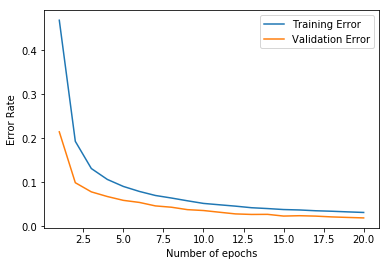

In [6]:
plt.plot(range(1,epocs+1), train_errors)
plt.plot(range(1,epocs+1), val_errors)
plt.legend(["Training Error", "Validation Error"])
plt.xlabel('Number of epochs')
plt.ylabel('Error Rate')
plt.show()

It appears that the more epocs, the lower the error. However, there are dimishing returns to adding more epocs as the decrease in error rate decreases. This is the expected behavior as evidently more iterations will improve the model. The time per epoc is constant and thus, the benefit from each epoc is decreasing.

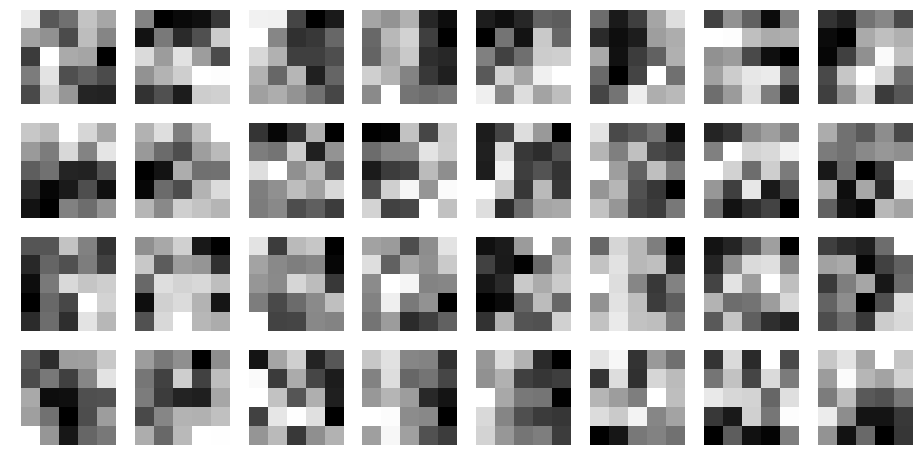

In [8]:
show_layer_image(model.layers[0].get_weights()[0].T, 4, 8)

### (b) Experiment with changing parameters of the network:

#### i. Keep the same number of layers and change layer parameters reducing number of parameters by half and doubling the number parameters. Try a few different options. Report the results.

In [10]:
filter_parameters = [(8,16), (16,32), (32, 64), (64,128), (128,256)]
filter_scale = [0.25, 0.5, 1, 2, 4]
ftrain_errors = []
fval_errors = []
ftime = []
for f in filter_parameters:
    print("Running with", f, "filters")
    model = getModel(f1 = f[0], f2= f[1])
    start = time.time()
    hist = model.fit(x=train_set[0], y=train_set[1],
              epochs=7, batch_size=500,
              shuffle=True,
              validation_data=val_set)
    ftime.append(time.time() - start)
    ftrain_errors.append(1- hist.history.get('acc')[-1])
    fval_errors.append(1- hist.history.get('val_acc')[-1])

Running with (8, 16) filters
Train on 50000 samples, validate on 10000 samples
Epoch 1/7
50000/50000 [==============================] - 3s 64us/step - loss: 2.0927 - acc: 0.3421 - val_loss: 1.6321 - val_acc: 0.7480
Epoch 2/7
50000/50000 [==============================] - 2s 38us/step - loss: 1.1438 - acc: 0.6796 - val_loss: 0.5992 - val_acc: 0.8548
Epoch 3/7
50000/50000 [==============================] - 2s 38us/step - loss: 0.6996 - acc: 0.7820 - val_loss: 0.4072 - val_acc: 0.8975
Epoch 4/7
50000/50000 [==============================] - 2s 39us/step - loss: 0.5562 - acc: 0.8270 - val_loss: 0.3316 - val_acc: 0.9138
Epoch 5/7
50000/50000 [==============================] - 2s 38us/step - loss: 0.4773 - acc: 0.8544 - val_loss: 0.2894 - val_acc: 0.9225
Epoch 6/7
50000/50000 [==============================] - 2s 38us/step - loss: 0.4263 - acc: 0.8681 - val_loss: 0.2541 - val_acc: 0.9309
Epoch 7/7
50000/50000 [==============================] - 2s 38us/step - loss: 0.3855 - acc: 0.8825 - val_

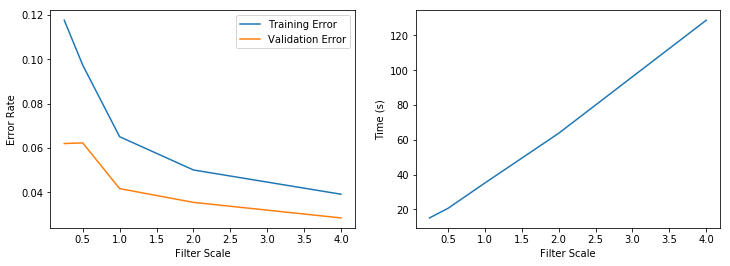

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(filter_scale, ftrain_errors)
plt.plot(filter_scale, fval_errors)
plt.legend(["Training Error", "Validation Error"])
plt.xlabel('Filter Scale')
plt.ylabel('Error Rate')
plt.subplot(1, 2, 2)
plt.plot(filter_scale, ftime)
plt.xlabel('Filter Scale')
plt.ylabel('Time (s)')
plt.show()

The results from the number of numbers is extremely similar to the results from the number of epochs. As the number of filters increases, the error rate decreases at a decreasing rate. Thus, the more filters we have, the better the results. The runtime appears to increase linearly. Thus, increasing the filter size has diminishing returns.

In [8]:
filterdd_parameters = [1,3,5,7,9]
fdtrain_errors = []
fdval_errors = []
fdtime = []
for fd in filterdd_parameters:
    print("Running with dimension:", fd,"x",fd)
    model = getModel(numF = 5)
    start = time.time()
    hist = model.fit(x=train_set[0], y=train_set[1],
              epochs=7, batch_size=500,
              shuffle=True,
              validation_data=val_set)
    fdtime.append(time.time() - start)
    fdtrain_errors.append(1- hist.history.get('acc')[-1])
    fdval_errors.append(1- hist.history.get('val_acc')[-1])

Running with dimension: 1 x 1
Train on 50000 samples, validate on 10000 samples
Epoch 1/7
50000/50000 [==============================] - 6s 119us/step - loss: 1.6473 - acc: 0.5246 - val_loss: 0.6766 - val_acc: 0.7936
Epoch 2/7
50000/50000 [==============================] - 5s 95us/step - loss: 0.6006 - acc: 0.8105 - val_loss: 0.3547 - val_acc: 0.9023
Epoch 3/7
50000/50000 [==============================] - 5s 95us/step - loss: 0.4223 - acc: 0.8715 - val_loss: 0.2804 - val_acc: 0.9179
Epoch 4/7
50000/50000 [==============================] - 5s 94us/step - loss: 0.3439 - acc: 0.8958 - val_loss: 0.2299 - val_acc: 0.9327
Epoch 5/7
50000/50000 [==============================] - 5s 95us/step - loss: 0.2929 - acc: 0.9100 - val_loss: 0.1943 - val_acc: 0.9437
Epoch 6/7
50000/50000 [==============================] - 5s 94us/step - loss: 0.2548 - acc: 0.9240 - val_loss: 0.1659 - val_acc: 0.9510
Epoch 7/7
50000/50000 [==============================] - 5s 95us/step - loss: 0.2233 - acc: 0.9329 - va

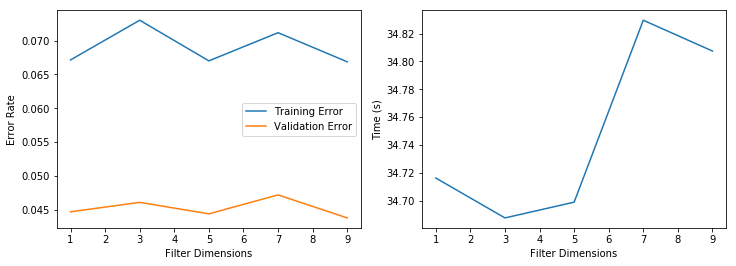

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(filterdd_parameters, fdtrain_errors)
plt.plot(filterdd_parameters, fdval_errors)
plt.legend(["Training Error", "Validation Error"])
plt.xlabel('Filter Dimensions')
plt.ylabel('Error Rate')
plt.subplot(1, 2, 2)
plt.plot(filterdd_parameters, fdtime)
plt.xlabel('Filter Dimensions')
plt.ylabel('Time (s)')
plt.show()

The filter demensions have interesting results. The error rate does not seem to depend very much on the dimensions (kernal size) of the filter. The results were best with a kernal size of 5x5 and 9x9. Also, the difference in time is extremely small as shown by the scale on the time graph. Thus, I will conclude that dimensions of filters does not have a very significant impact on the results.

#### ii. Design a deeper network with the same number of parameters as the original net- work. Report the results.

In [6]:
depth_parameters = [1,2,3] 
dtrain_errors = []
dval_errors = []
dtime = []
for d in depth_parameters:
    print("Running with depth:", d)
    model = getModel(depth = d)
    start = time.time()
    hist = model.fit(x=train_set[0], y=train_set[1],
              epochs=10, batch_size=500,
              shuffle=True,
              validation_data=val_set)
    dtime.append(time.time() - start)
    dtrain_errors.append(1- hist.history.get('acc')[-1])
    dval_errors.append(1- hist.history.get('val_acc')[-1])

Running with depth: 1
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 145us/step - loss: 1.5498 - acc: 0.5629 - val_loss: 0.5914 - val_acc: 0.8489
Epoch 2/10
50000/50000 [==============================] - 5s 95us/step - loss: 0.5708 - acc: 0.8199 - val_loss: 0.3554 - val_acc: 0.8991
Epoch 3/10
50000/50000 [==============================] - 5s 97us/step - loss: 0.4085 - acc: 0.8762 - val_loss: 0.2715 - val_acc: 0.9210
Epoch 4/10
50000/50000 [==============================] - 5s 98us/step - loss: 0.3292 - acc: 0.9008 - val_loss: 0.2200 - val_acc: 0.9358
Epoch 5/10
50000/50000 [==============================] - 5s 98us/step - loss: 0.2772 - acc: 0.9168 - val_loss: 0.1815 - val_acc: 0.9481
Epoch 6/10
50000/50000 [==============================] - 5s 98us/step - loss: 0.2405 - acc: 0.9286 - val_loss: 0.1581 - val_acc: 0.9538
Epoch 7/10
50000/50000 [==============================] - 5s 97us/step - loss: 0.2164 - acc: 0.9354 - val

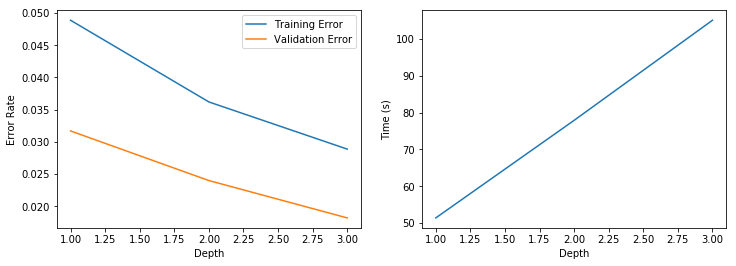

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(depth_parameters, dtrain_errors)
plt.plot(depth_parameters, dval_errors)
plt.legend(["Training Error", "Validation Error"])
plt.xlabel('Depth')
plt.ylabel('Error Rate')
plt.subplot(1, 2, 2)
plt.plot(depth_parameters, dtime)
plt.xlabel('Depth')
plt.ylabel('Time (s)')
plt.show()

The error rate decreases slightly as depth increases. This is the expected behavior as a more complex network will better represent the input data. However, it is important to note that the increase in time is extremely dramatic. This is also expected as a more complex network takes a lot longer to train. I didn't test anything above a depth of 3 as I figured it would take too long.

#### iii. Once you pick the best configuration try it on the full training set and report the result

We will use 20 epochs, filter sizes of 128 and 256, filter dimensions of 5x5 and a depth of 3 as this gets the best results. However, it should be noted that it takes ~8-10 minutes to run on the full data set. However, as a classifier is normally trained once, I feel like this is accepetable.

In [29]:
model = getModel(f1 = 64, f2 = 128, numF = 5, depth = 3)
hist = model.fit(x=train_set[0], y=train_set[1],
              epochs=20, batch_size=500,
              shuffle=True,
              validation_data=val_set)
test_error = 1- model.evaluate(test_set[0], test_set[1])[1]
print("The training error rate is", 1- hist.history.get('acc')[-1])
print("The validaiton error rate is", 1- hist.history.get('val_acc')[-1])
print("The testing error rate is", test_error)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 24s 480us/step - loss: 1.3335 - acc: 0.5761 - val_loss: 0.3720 - val_acc: 0.8831
Epoch 2/20
50000/50000 [==============================] - 21s 415us/step - loss: 0.3039 - acc: 0.9060 - val_loss: 0.1561 - val_acc: 0.9515
Epoch 3/20
50000/50000 [==============================] - 21s 418us/step - loss: 0.1867 - acc: 0.9431 - val_loss: 0.1166 - val_acc: 0.9613
Epoch 4/20
50000/50000 [==============================] - 21s 417us/step - loss: 0.1402 - acc: 0.9562 - val_loss: 0.0894 - val_acc: 0.9702
Epoch 5/20
50000/50000 [==============================] - 21s 418us/step - loss: 0.1149 - acc: 0.9636 - val_loss: 0.0719 - val_acc: 0.9763
Epoch 6/20
50000/50000 [==============================] - 21s 418us/step - loss: 0.1004 - acc: 0.9685 - val_loss: 0.0660 - val_acc: 0.9766
Epoch 7/20
50000/50000 [==============================] - 21s 418us/step - loss: 0.0900 - acc: 0.9717 - val_loss: 0.

This error rate is extremely good and thus our optimal model performed extremely well. It does take a long time and the error decreases marginally after the first 8 or so epochs. However, the marginal increase is defintely beneficial if this model was actually going to be used in practice and thus the time cost is worth the increase in accuracy.

### (c) Handling variability. A transformed data set /project/cmsc25025/mnist/MNIST TRANSFOR has been created by taking each digit, rotating it by a random angle between [-40,-20]or [20,40], applying a random shift of +/− 3 pixels in each direction and applying a random scale between [.9, 1.1].


In [5]:
XT = np.load('/project2/cmsc25025/mnist/MNIST_TEST_TRANS.npy').reshape(-1,28,28,1).astype(np.float64) / 255.
n = 70000
trans_train_set = (XT[:int(5/7 * n)], Y[:int(5/7 * n)])
trans_val_set = (XT[int(5/7 * n):int(6/7 * n)], Y[int(5/7 * n):int(6/7 * n)])
trans_test_set = (XT[int(6/7 * n):n], Y[int(6/7 * n):n])

#### Display a few of these examples alongside the original digits.

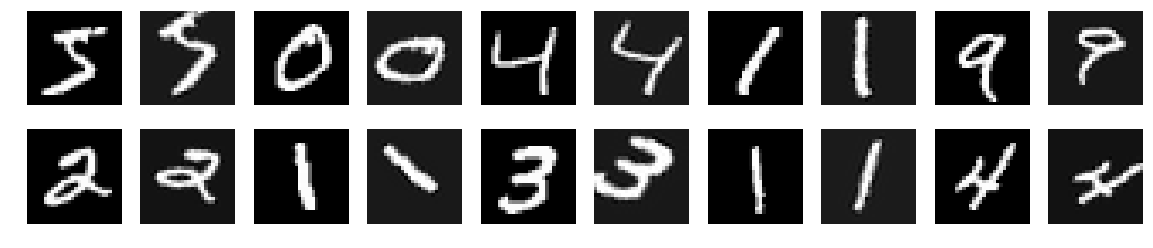

In [10]:
XXT = []
for i in range(10):
    XXT.append(X[i])
    XXT.append(XT[i])

XXT = np.array(XXT)
show_image(XXT,2,10)

#### Using the original architecture to test on this data set. The classification rate drops dramatically.

In [7]:
model = getModel()
hist = model.fit(x=trans_train_set[0], y=trans_train_set[1],
              epochs=10, batch_size=500,
              shuffle=True,
              validation_data=trans_val_set)
test_error = 1- model.evaluate(trans_test_set[0], trans_test_set[1])[1]
print("The training error rate is", 1- hist.history.get('acc')[-1])
print("The validaiton error rate is", 1- hist.history.get('val_acc')[-1])
print("The testing error rate is", test_error)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 101us/step - loss: 2.3022 - acc: 0.1135 - val_loss: 2.3019 - val_acc: 0.1135
Epoch 2/10
50000/50000 [==============================] - 4s 87us/step - loss: 2.3017 - acc: 0.1136 - val_loss: 2.3015 - val_acc: 0.1135
Epoch 3/10
50000/50000 [==============================] - 4s 87us/step - loss: 2.3013 - acc: 0.1136 - val_loss: 2.3013 - val_acc: 0.1135
Epoch 4/10
50000/50000 [==============================] - 4s 87us/step - loss: 2.3011 - acc: 0.1136 - val_loss: 2.3011 - val_acc: 0.1135
Epoch 5/10
50000/50000 [==============================] - 4s 87us/step - loss: 2.3010 - acc: 0.1136 - val_loss: 2.3010 - val_acc: 0.1135
Epoch 6/10
50000/50000 [==============================] - 4s 87us/step - loss: 2.3009 - acc: 0.1136 - val_loss: 2.3009 - val_acc: 0.1135
Epoch 7/10
50000/50000 [==============================] - 4s 87us/step - loss: 2.3008 - acc: 0.1136 - val_loss: 2.3008 - val_ac

#### Try to propose changes to the network architecture so that still training on the original training set you would perform better on the transformed test set. Perform some experiments using a transformed validation set and show the final results on the transformed test set.

First, I will run the model with the original train data and the transformed validation set.

In [85]:
model = getModel()
hist = model.fit(x=train_set[0], y=train_set[1],
              epochs=10, batch_size=500,
              shuffle=True,
              validation_data=trans_val_set)
print("The transformed validation error rate is", 1- hist.history.get('val_acc')[-1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 164us/step - loss: 1.6698 - acc: 0.5278 - val_loss: 2.2973 - val_acc: 0.1282
Epoch 2/10
50000/50000 [==============================] - 4s 88us/step - loss: 0.5667 - acc: 0.8221 - val_loss: 2.2980 - val_acc: 0.1135
Epoch 3/10
50000/50000 [==============================] - 4s 88us/step - loss: 0.3891 - acc: 0.8839 - val_loss: 2.2979 - val_acc: 0.1135
Epoch 4/10
50000/50000 [==============================] - 4s 88us/step - loss: 0.3165 - acc: 0.9056 - val_loss: 2.2977 - val_acc: 0.1135
Epoch 5/10
50000/50000 [==============================] - 4s 88us/step - loss: 0.2709 - acc: 0.9195 - val_loss: 2.2973 - val_acc: 0.1135
Epoch 6/10
50000/50000 [==============================] - 4s 88us/step - loss: 0.2345 - acc: 0.9289 - val_loss: 2.2964 - val_acc: 0.1135
Epoch 7/10
50000/50000 [==============================] - 4s 88us/step - loss: 0.2130 - acc: 0.9362 - val_loss: 2.2957 - val_ac

To prevent overfitting and increase the accuracy in the validation set, I tried multiple things. This includes using a lower number of filters, using a lower kernal size changing the depth, changing the dropout rate and adding a regularizer. Generally, I tried to make changes that would make the model less specific and thus overfit less. <br>

Here is the best model that I came up with:

In [95]:
def getTransformedModel(f1 = 32, f2 = 64, numF = 5, depth = 1):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer((28,28,1)))
    model.add(keras.layers.Conv2D(filters=f1, kernel_size=(numF,numF), padding='same', activation='relu', kernel_regularizer = keras.regularizers.l2(0.05)))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Dropout(rate=0.4))
    for i in range(depth):
        model.add(keras.layers.Conv2D(filters=f2, kernel_size=(numF,numF), padding='same', activation='relu', kernel_regularizer = keras.regularizers.l2(0.05)))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=1024, activation='relu'))
    model.add(keras.layers.Dense(units=10, activation='softmax'))
    model.compile(optimizer=tf.train.AdadeltaOptimizer(0.1),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [96]:
model = getTransformedModel(f1 = 16, f2=64)
hist = model.fit(x=train_set[0], y=train_set[1],
              epochs=10, batch_size=500,
              shuffle=True,
              validation_data=trans_val_set)
print("The transformed validation error rate is", 1- hist.history.get('val_acc')[-1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 157us/step - loss: 1.8966 - acc: 0.5349 - val_loss: 2.5617 - val_acc: 0.1652
Epoch 2/10
50000/50000 [==============================] - 3s 70us/step - loss: 0.8918 - acc: 0.8034 - val_loss: 2.5478 - val_acc: 0.1687
Epoch 3/10
50000/50000 [==============================] - 4s 70us/step - loss: 0.7137 - acc: 0.8548 - val_loss: 2.5348 - val_acc: 0.1553
Epoch 4/10
50000/50000 [==============================] - 4s 70us/step - loss: 0.6284 - acc: 0.8769 - val_loss: 2.5221 - val_acc: 0.1527
Epoch 5/10
50000/50000 [==============================] - 4s 70us/step - loss: 0.5673 - acc: 0.8943 - val_loss: 2.5105 - val_acc: 0.1279
Epoch 6/10
50000/50000 [==============================] - 4s 70us/step - loss: 0.5229 - acc: 0.9030 - val_loss: 2.5001 - val_acc: 0.1289
Epoch 7/10
50000/50000 [==============================] - 4s 70us/step - loss: 0.4846 - acc: 0.9127 - val_loss: 2.4907 - val_ac

None of my proposed changes worked too well. The best error rate I got from making changes was 0.83 when I used regularization and less filters on the first filter layer. Unfortunately, this is still very high. It is interesting to see how hard it is to make a model that can work on transformed data. I generally found that the validation error rate decreased as more epochs were run. This makes sense as more epochs specifies the model more, but  the goal is to have a model that can be trained with more epochs and not have the validiation error rate decrease.